In [763]:
import numpy as np
import matplotlib.pyplot as plt

In [764]:
## Game constants
ACTIONS              = ['UP', 'RIGHT', 'DOWN', 'LEFT', 'WAIT', 'BOMB']
DIRECTIONS           = np.array([(0, -1), (1, 0), (0, 1), (-1, 0)])   # UP, RIGHT, DOWN, LEFT
DEFAULT_DISTANCE     = 1000
BOMB_COOLDOWN_TIME   = 7
COLS = ROWS          = 17
BLAST                = np.array([-3, -2, -1, 1, 2, 3])
MAX_WAITING_TIME     = 6

## Calculate constant BOMB_MASK one time
BOMB_MASK = np.full((COLS, ROWS, COLS, ROWS), False)

x_inside = lambda x: x > 0 and x < COLS-1
y_inside = lambda y: y > 0 and y < ROWS-1

for x in range(1, COLS-1):
        for y in range(1, ROWS-1):
            if (x % 2 == 1 or y % 2 == 1):
                explosion_spots = [(x, y)]
                if x % 2 == 1:
                    explosion_spots += [(x, y + b) for b in BLAST  if y_inside(y + b)]
                if y % 2 == 1:
                    explosion_spots += [(x + b, y) for b in BLAST  if x_inside(x + b)]
                
                explosion_spots = tuple(np.array(explosion_spots).T)
                BOMB_MASK[(x, y)][explosion_spots] \
                                = True

''' state to features 
own_position      = game_state['self'][3]
crate_map         = game_state['field']
can_place_bomb    = game_state['self'][2]
collectable_coins = game_state['coins']
bombs             = game_state['bombs']
explosion_map     = game_state['explosion_map']
foes              = game_state['others']

neighbors = own_position + DIRECTIONS
'''


" state to features \nown_position      = game_state['self'][3]\ncrate_map         = game_state['field']\ncan_place_bomb    = game_state['self'][2]\ncollectable_coins = game_state['coins']\nbombs             = game_state['bombs']\nexplosion_map     = game_state['explosion_map']\nfoes              = game_state['others']\n\nneighbors = own_position + DIRECTIONS\n"

In [765]:
def create_mask(positions, shape = (ROWS, COLS)):
    array = np.zeros_like(shape)
    indices = tuple(np.array(positions).T)
    array[indices] = True
    return(array)

def build_free_spacetime_map(own_position, game_field, explosion_map, bombs, foe_map):
    free_spacetime = np.resize(np.logical_and(game_field == 0, foe_map == 0), (7, ROWS, COLS)) # exclude crates, walls and foes
    free_spacetime[1][np.nonzero(explosion_map)] = False # exclude present explosions
    free_spacetime[0][np.nonzero(explosion_map)] = False

    for ((x,y), bomb_timer) in bombs: 
        steps_until_explosion = bomb_timer + 1
        start = 1 if (x,y) == own_position else 0
        free_spacetime[start:steps_until_explosion, x, y] = np.zeros(steps_until_explosion - start) # exclude bomb spots as long as bomb is present
        '''
        if (x,y) == own_position:
            free_spacetime[tuple(np.array([(n,x,y) for n in range(1, steps_until_explosion)]).T)] = False # exclude bomb spots as long as bomb is present
        else:
            free_spacetime[tuple(np.array([(n,x,y) for n in range(steps_until_explosion)]).T)] = False # exclude bomb spots as long as bomb is present
        '''
        free_spacetime[steps_until_explosion:][np.resize(np.logical_and(BOMB_MASK[(x,y)], np.logical_or(game_field == 1, foe_map)), (7 - steps_until_explosion, ROWS, COLS))] = True # include crates and foes destroyed by explosion 
        free_spacetime[steps_until_explosion : steps_until_explosion+2][np.resize(BOMB_MASK[(x,y)], (2, ROWS, COLS))] = False # exclude future explosions as long as present

    return(free_spacetime)

In [766]:

def proximity_map_old(own_position, game_field, explosion_map, bombs):
    """
    calculates three values for each tile of the game field:
    1. travel time aka. distance from own position
    2. if tile is reachable from own position or blocked
    3. in which directions one can initially go to reach that tile as quick as possible

    Arguments
    ---------
    own_position : tuple (x, y)
        with x and y being current coordinates coordinates of the agent 
        on the game field. Thus 0 < x < COLS-1, 0 < y < ROWS-1.
    game_field   : np.array, shape = (COLS, ROWS)
        = game_state['field']

    Returns
    -------
    travel_time_map         : np.array, shape like game_field, dtype = int
        Reachable tiles have the value of the number of steps it takes to move to them 
        from own_position.
        Unreachable tiles have the value of DEFAULT_TRAVEL_TIME which is much higher than 
        any reachable time.
    reachable_map           : np.array, shape like game_field, dtype = bool
        A boolean mask of travel_time_map that labels reachable tiles as True and 
        unreachable ones as False.
    original_directions_map : np.array, shape = (COLS, ROWS, 4), dtype = bool
        A map of the game_field that holds a 4-element boolean array for every tile.
        Values of the tile's array correspond to the 4 directions UP, RIGHT, DOWN, LEFT 
        which you might from own_position to reach the tile. Those direction which lead you 
        to reach the tile the fastest are marked True, the others False.
        For example, if you can reach a tile the fastest by either going UP or RIGHT at the step
        then its array will look like this [TRUE, TRUE, FALSE, FALSE].
        This map will be important to quickly find the best direction towards coins, crates,
        opponents and more.
    """

    # Setup of initial values
    free_spacetime_map = build_free_spacetime_map(own_position, game_field, explosion_map, bombs)
    distance_time_map  = np.full((ROWS, COLS), DEFAULT_DISTANCE)
    direction_map = np.full((ROWS, COLS, 5), False) # UP, RIGHT, DOWN, LEFT, WAIT

    distance_time_map[own_position] = 0
    direction_map[own_position][4] = True
    for i, dir in enumerate(DIRECTIONS):
        neighbor = tuple(dir + np.array(own_position)) 
        direction_map[neighbor][i] = free_spacetime_map[1][neighbor] # If neighbor is a free field in next step
    

    # Breadth first search for proximity values to all reachable spots
    frontier = [own_position]
    while len(frontier) > 0:
        current = frontier.pop(0)
        
        waiting_time_until_explosion = np.argmin(free_spacetime_map[:, current[0], current[1]])
        maximal_waiting_time = min(MAX_WAITING_TIME, waiting_time_until_explosion)

        for waiting_time in range(maximal_waiting_time+1):
            
            for dir in DIRECTIONS:
                neighbor = tuple(dir + np.array(current))
    
                # Update travel time to `neighbor` field
                time = distance_time_map[current] + waiting_time + 1
                if free_spacetime_map[min(time, 6)][neighbor]:
                    if distance_time_map[neighbor] > time:
                        distance_time_map[neighbor] = time
                        frontier.append(neighbor)
                    
                        # Update original direction for `neighbor` field
                        if time > 1:
                            direction_map[neighbor] = direction_map[current]
                        
                    # Combine orginial directions if travel times are equal
                    elif distance_time_map[neighbor] == time:
                        direction_map[neighbor] = np.logical_or(direction_map[neighbor], direction_map[current])
            

    # Derivation of reachability_map
    reachability_map = distance_time_map != DEFAULT_DISTANCE
    return distance_time_map, reachability_map, direction_map


def proximity_map(own_position, game_field, explosion_map, bombs, foe_map):
    """
    calculates three values for each tile of the game field:
    1. travel time aka. distance from own position
    2. if tile is reachable from own position or blocked
    3. in which directions one can initially go to reach that tile as quick as possible

    Arguments
    ---------
    own_position : tuple (x, y)
        with x and y being current coordinates coordinates of the agent 
        on the game field. Thus 0 < x < COLS-1, 0 < y < ROWS-1.
    game_field   : np.array, shape = (COLS, ROWS)
        = game_state['field']

    Returns
    -------
    travel_time_map         : np.array, shape like game_field, dtype = int
        Reachable tiles have the value of the number of steps it takes to move to them 
        from own_position.
        Unreachable tiles have the value of DEFAULT_TRAVEL_TIME which is much higher than 
        any reachable time.
    reachable_map           : np.array, shape like game_field, dtype = bool
        A boolean mask of travel_time_map that labels reachable tiles as True and 
        unreachable ones as False.
    original_directions_map : np.array, shape = (COLS, ROWS, 4), dtype = bool
        A map of the game_field that holds a 4-element boolean array for every tile.
        Values of the tile's array correspond to the 4 directions UP, RIGHT, DOWN, LEFT 
        which you might from own_position to reach the tile. Those direction which lead you 
        to reach the tile the fastest are marked True, the others False.
        For example, if you can reach a tile the fastest by either going UP or RIGHT at the step
        then its array will look like this [TRUE, TRUE, FALSE, FALSE].
        This map will be important to quickly find the best direction towards coins, crates,
        opponents and more.
    """

    # Setup of initial values
    free_spacetime_map = build_free_spacetime_map(own_position, game_field, explosion_map, bombs, foe_map)
    distance_time_map  = np.full((7, ROWS, COLS), DEFAULT_DISTANCE)
    direction_map = np.full((7, ROWS, COLS, 5), False) # UP, RIGHT, DOWN, LEFT, WAIT
    x_own, y_own = own_position

    distance_time_map[0, x_own, y_own] = 0
    direction_map[0, x_own, y_own][4] = free_spacetime_map[1, x_own, y_own]
    for i, step in enumerate([(0, -1), (1, 0), (0, 1), (-1, 0)]):
        x_next, y_next = np.array(step) + np.array(own_position)
        direction_map[1, x_next, y_next, i] = free_spacetime_map[1, x_next, y_next] # If neighbor is a free field in next step

    # Breadth first search for proximity values to all reachable spots
    frontier = [(0, x_own, y_own)]
    while len(frontier) > 0:
        current = t_current, x_current, y_current = frontier.pop(0)
        # print(current)

        currents_future = free_spacetime_map[min(t_current, 6):, x_current, y_current]
        waiting_time_limit = MAX_WAITING_TIME + 1 if np.all(currents_future) else min(MAX_WAITING_TIME + 1, np.argmin(currents_future))

        for waiting_time in range(waiting_time_limit):
            t_neighbor = t_current + waiting_time + 1

            for dir in [(0, -1), (1, 0), (0, 1), (-1, 0)]:
                x_neighbor, y_neighbor = np.array(dir) + np.array([x_current, y_current])
                neighbor = (min(t_neighbor, 6), x_neighbor, y_neighbor)
                
                # Update travel time to `neighbor` field
                if free_spacetime_map[neighbor]:
                    if distance_time_map[neighbor] > t_neighbor:
                        distance_time_map[neighbor] = t_neighbor
                        frontier.append((t_neighbor, x_neighbor, y_neighbor))
                    
                        # Update original direction for `neighbor` field
                        if t_neighbor > 1:
                            direction_map[neighbor] = direction_map[min(t_current, 6), x_current, y_current]
                            # print(f"1: {current}, {neighbor}")
                        
                    # Combine orginial directions if travel times are equal
                    elif distance_time_map[neighbor] == t_neighbor:
                        direction_map[neighbor] = np.logical_or(direction_map[neighbor], direction_map[min(t_current, 6), x_current, y_current])
                        # print(f"2: {current}, {neighbor}")

    shortest_distance_map = np.amin(distance_time_map, axis = 0)
    direction_map = np.take_along_axis(direction_map, np.argmin(distance_time_map, axis = 0).reshape(1, COLS, ROWS, 1), axis = 0).reshape(ROWS, COLS, 5)

    # Derivation of reachability_map
    reachability_map = shortest_distance_map != DEFAULT_DISTANCE

    return shortest_distance_map, reachability_map, direction_map

In [767]:
def proximity_no_waiting(own_position, game_field, explosion_map, bombs):
    """
    calculates three values for each tile of the game field:
    1. travel time aka. distance from own position
    2. if tile is reachable from own position or blocked
    3. in which directions one can initially go to reach that tile as quick as possible

    Arguments
    ---------
    own_position : tuple (x, y)
        with x and y being current coordinates coordinates of the agent 
        on the game field. Thus 0 < x < COLS-1, 0 < y < ROWS-1.
    game_field   : np.array, shape = (COLS, ROWS)
        = game_state['field']

    Returns
    -------
    travel_time_map         : np.array, shape like game_field, dtype = int
        Reachable tiles have the value of the number of steps it takes to move to them 
        from own_position.
        Unreachable tiles have the value of DEFAULT_TRAVEL_TIME which is much higher than 
        any reachable time.
    reachable_map           : np.array, shape like game_field, dtype = bool
        A boolean mask of travel_time_map that labels reachable tiles as True and 
        unreachable ones as False.
    original_directions_map : np.array, shape = (COLS, ROWS, 4), dtype = bool
        A map of the game_field that holds a 4-element boolean array for every tile.
        Values of the tile's array correspond to the 4 directions UP, RIGHT, DOWN, LEFT 
        which you might from own_position to reach the tile. Those direction which lead you 
        to reach the tile the fastest are marked True, the others False.
        For example, if you can reach a tile the fastest by either going UP or RIGHT at the step
        then its array will look like this [TRUE, TRUE, FALSE, FALSE].
        This map will be important to quickly find the best direction towards coins, crates,
        opponents and more.
    """

    # Setup of initial values
    free_spacetime_map = build_free_spacetime_map(own_position, game_field, explosion_map, bombs)
    distance_time_map  = np.full((ROWS, COLS), DEFAULT_DISTANCE)
    direction_map = np.full((ROWS, COLS, 4), False) # UP, RIGHT, DOWN, LEFT, WAIT

    distance_time_map[own_position] = 0
    for i, dir in enumerate(DIRECTIONS):
        neighbor = tuple(dir + np.array(own_position)) 
        direction_map[neighbor][i] = free_spacetime_map[1][neighbor] # If neighbor is a free field in next step

    # Breadth first search for proximity values to all reachable spots
    frontier = [own_position]
    while len(frontier) > 0:
        current = frontier.pop(0)
        for dir in DIRECTIONS:
            neighbor = tuple(dir + np.array(current))
    
            # Update travel time to `neighbor` field
            time = distance_time_map[current] + 1
            if free_spacetime_map[min(time, 6)][neighbor]:
                if distance_time_map[neighbor] > time:
                    distance_time_map[neighbor] = time
                    frontier.append(neighbor)
                    
                    # Update original direction for `neighbor` field
                    if time > 1:
                        direction_map[neighbor] = direction_map[current]
                        
                # Combine orginial directions if travel times are equal
                elif distance_time_map[neighbor] == time:
                    direction_map[neighbor] = np.logical_or(direction_map[neighbor], direction_map[current])
            
    # Derivation of reachability_map
    reachability_map = distance_time_map != DEFAULT_DISTANCE
    return distance_time_map, reachability_map, direction_map

# Test

In [768]:
# Test crate maps

empty_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)


halffull_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1],
     [-1,  1,  0,  1,  0,  0,  0,  1,  1,  1,  0,  0,  1,  0,  1,  1, -1],
     [-1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  1,  1,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0, -1],
     [-1,  1, -1,  0, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

packed_game_field = np.array(
    [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0, -1],
     [-1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  0, -1],
     [-1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1, -1],
     [-1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  0, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1],
     [-1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1, -1],
     [-1,  1, -1,  1, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  0, -1],
     [-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0, -1],
     [-1,  1, -1,  0, -1,  1, -1,  0, -1,  1, -1,  1, -1,  1, -1,  1, -1],
     [-1,  0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  0, -1],
     [-1,  0, -1,  1, -1,  0, -1,  0, -1,  0, -1,  0, -1,  1, -1,  0, -1],
     [-1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0, -1],
     [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]]
)

# Test positions
positions_empty_field    = [(11, 5), (9, 7), (7, 5), (13, 9), (9, 9), (5, 7), (5, 8), (11, 7)]
positions_halffull_field = [(11, 5), (13, 7), (15, 4), (13, 2), (7, 5), (13, 8), (14, 1)]
positions_packed_field   = [(15, 1), (1, 1)]

# Test bomb placements
bombs_none = []
bombs_some = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1)]
bombs_many = [((11, 5), 4), ((1, 1), 2), ((7, 6), 0), ((5, 11), 1), ((5, 7), 2), ((7, 13), 3), ((15, 12), 0)]

# Test Explosions positions
explosion_map = np.zeros((17,17), dtype = np.int8)
foe_map = np.zeros((17,17), dtype = np.int8)

## Test spacetime

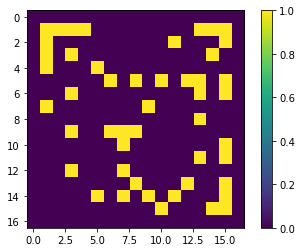

In [769]:
game_field = packed_game_field
own_position = (1,1)
bombs = [((1,1), 0), ((15,1),3)]
explosion_map[(15,15,14), (14,15,15)] = 0
foe_map[(2,1)] = 1

free_spacetime = build_free_spacetime_map(own_position, game_field, explosion_map, bombs, foe_map)
plt.imshow(free_spacetime[4])
plt.colorbar()

## Test Proximity maps

In [770]:
def show_proximity_results (results):
    # Unpack maps
    travel_time_map, reachable_map, original_directions_map = results

    plt.figure(figsize=(24, 6))

    # Show travel time map
    plt.subplot(1, 3, 1)
    adapted_travel_time_map = np.where(travel_time_map == DEFAULT_DISTANCE, 
        np.full_like(travel_time_map, -1), travel_time_map
    )
    plt.imshow(adapted_travel_time_map.T, vmax=28, vmin=-1)
    plt.colorbar()
    plt.title("Travel times")

    # Show map of reachable area
    plt.subplot(1, 3, 2)
    plt.imshow(reachable_map.T)
    plt.colorbar()
    plt.title("Reachable area")
    
    # Show map of amount of original directions
    plt.subplot(1, 3, 3)
    number_of_ori_dirs_map = np.count_nonzero(original_directions_map, axis = 2)
    plt.imshow(number_of_ori_dirs_map.T, vmin=0, vmax=5)
    plt.colorbar()
    plt.title("Number of original directions")

    plt.show()


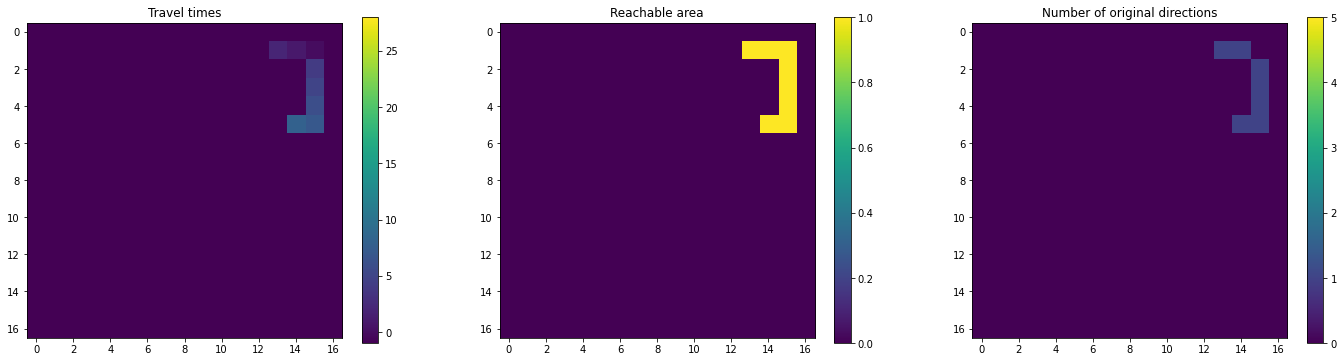

[False False False  True False]
3.84 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0

In [772]:
bombs = [((15,2), 0)]
explosion_map[(15,15,14), (14,15,15)] = 0
foe_map[(1,2)] = 0
travel_time_map, reachable_map, directions_map = proximity_map((15, 1), packed_game_field, explosion_map, bombs, foe_map)
proximity_maps = travel_time_map, reachable_map, directions_map
show_proximity_results(proximity_maps)
print(directions_map[(15,2)])

%timeit proximity_map((15, 1), packed_game_field, explosion_map, bombs, foe_map)

packed_game_field[(14,5)]

In [ ]:
bombs = [((13,4), 0), ((8,5), 1)]
explosion_map[(11, 5)] = 0
travel_time_map, reachable_map, directions_map = proximity_map((12, 5), halffull_game_field, explosion_map, bombs)
proximity_maps = travel_time_map, reachable_map, directions_map
# show_proximity_results(proximity_maps)

# directions_map[(13,5)]
# travel_time_map[(10,5)]

%timeit proximity_map((12, 5), halffull_game_field, explosion_map, bombs)


7.24 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


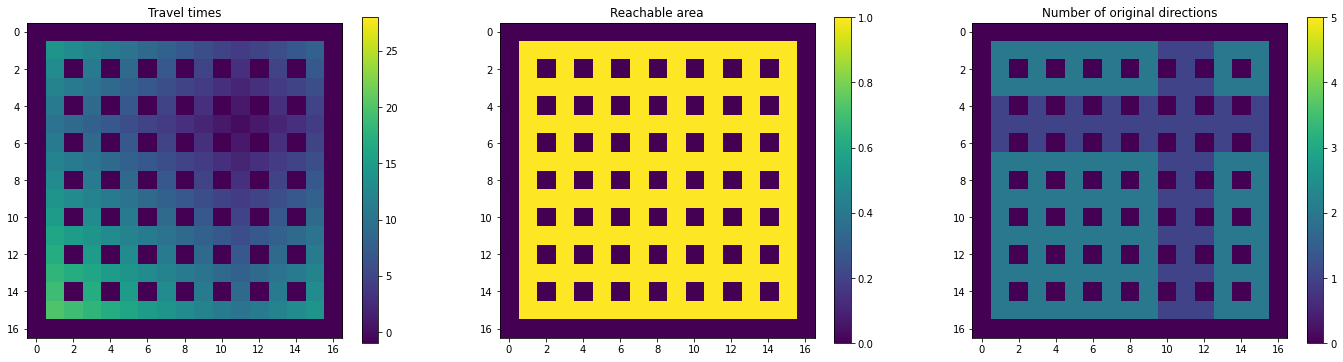

23.6 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.3 µs ± 697 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
bombs = [] # [((13,4), 0)]
explosion_map[(11, 5)] = 0
travel_time_map, reachable_map, directions_map = proximity_map((11, 5), empty_game_field, explosion_map, bombs)
proximity_maps = travel_time_map, reachable_map, directions_map
show_proximity_results(proximity_maps)

# directions_map[(13,6)]
# travel_time_map[(13,6)]

%timeit proximity_map((11, 5), empty_game_field, explosion_map, bombs)

%timeit build_free_spacetime_map(own_position, game_field, explosion_map, bombs)

In [ ]:
A = np.array([1,2,3])
A[0:]



array([1, 2, 3])